<a href="https://colab.research.google.com/github/Jaew00/DeepLearning/blob/main/%5B%EC%8B%A4%EC%8A%B505%5D_%ED%95%A9%EC%84%B1%EA%B3%B1_%EC%8B%A0%EA%B2%BD%EB%A7%9D_%EA%B3%BC%EC%A0%9C_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Settings

> 1) Important required libraries




In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.utils.data as data
import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt
import utils
%matplotlib inline

2) Hyperparameter

In [2]:
batch_size = 128
learning_rate = 0.0001
epoch = 20

n_node = 1024
dropratio = 0.5
imgsize = 128

2. Data Loader

트레이닝 데이터

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
class_name = pd.read_csv('/content/drive/MyDrive/학교 수업 자료/18. 심층학습/12주차/butterflies/CLASS NAMES.csv')

In [5]:
class_name.head()

,COMMON NAME,SCIENTIFIC NAME
0,ADONIS,Lysandra bellargus
1,AFRICAN GIANT SWALLOWTAIL,Papilio antimachus
2,AMERICAN SNOOT,Libytheana carinenta
3,AN 88,Diaethria anna
4,APPOLLO,Parnassius apollo


In [6]:
img_dir = "/content/drive/MyDrive/학교 수업 자료/18. 심층학습/12주차/butterflies/train"
train_data = dset.ImageFolder(img_dir, transforms.Compose([
              #transforms.CenterCrop(imgsize*2),
              #transforms.RandomCrop(imgsize),
              #transforms.RandomHorizontalFlip(),
              transforms.Resize(imgsize),
              transforms.ToTensor()
              ]))
print(train_data.__len__())

train_batch = data.DataLoader(train_data, batch_size = batch_size,
                              shuffle = True, num_workers=2, drop_last=True)

730


고정된 데이터 셋

In [7]:
# 2. Dev data
img_dir = "/content/drive/MyDrive/학교 수업 자료/18. 심층학습/12주차/butterflies/valid"
dev_data = dset.ImageFolder(img_dir, transforms.Compose([
              #transforms.Scale(256),
              #transform.RandomSizedCrop(224),                                           
              #transforms.CenterCrop(imgsize),

              transforms.Resize(imgsize),
              transforms.ToTensor()
              ]))
print(dev_data.__len__())

dev_batch = data.DataLoader(dev_data, batch_size = batch_size,
                              shuffle = False, num_workers=2, drop_last=False)

30


In [8]:
# Test data
img_dir = "/content/drive/MyDrive/학교 수업 자료/18. 심층학습/12주차/butterflies/test"
test_data = dset.ImageFolder(img_dir, transforms.Compose([
              #transforms.Scale(256),
              #transform.RandomSizedCrop(224),                                           
              #transforms.CenterCrop(imgsize),

              transforms.Resize(imgsize),
              transforms.ToTensor()
              ]))
print(test_data.__len__())

test_batch = data.DataLoader(test_data, batch_size = batch_size,
                              shuffle = False, num_workers=2, drop_last=False)

30


In [9]:
nclass = len(train_data.classes)
print("# of classes: %d" %nclass)
print(train_data.classes)
print(train_data.class_to_idx)
print(train_data.__len__())

print("Training: %d, Dev: %d, Test: %d" %(train_data.__len__(), dev_data.__len__(),test_data.__len__()))

# of classes: 6
['ADONIS', 'AFRICAN GIANT SWALLOWTAIL', 'AMERICAN SNOOT', 'AN 88', 'APPOLLO', 'ATALA']
{'ADONIS': 0, 'AFRICAN GIANT SWALLOWTAIL': 1, 'AMERICAN SNOOT': 2, 'AN 88': 3, 'APPOLLO': 4, 'ATALA': 5}
730
Training: 730, Dev: 30, Test: 30


In [10]:
print(train_data.classes)
print(dev_data.classes)
print(test_data.classes)

['ADONIS', 'AFRICAN GIANT SWALLOWTAIL', 'AMERICAN SNOOT', 'AN 88', 'APPOLLO', 'ATALA']
['ADONIS', 'AFRICAN GIANT SWALLOWTAIL', 'AMERICAN SNOOT', 'AN 88', 'APPOLLO', 'ATALA']
['ADONIS', 'AFRICAN GIANT SWALLOWTAIL', 'AMERICAN SNOOT', 'AN 88', 'APPOLLO', 'ATALA']


대략적인 데이터 형태

image data 형태: torch.Size([3, 128, 128])
label: 0


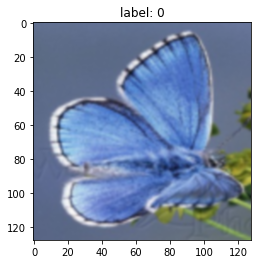

In [11]:
# 데이터 하나 형태
image, label = train_data.__getitem__(1) # 1번째 데이터
print("image data 형태:", image.size())
print("label:", label)

# 그리기
img = image.numpy() # image 타입을 numpy로 변환(3, 32, 32)

# (3, 32, 32) -> (32, 32, 3)
r, g, b = img[0,:,:], img[1,:,:], img[2,:,:]
# img = img.reshape(img.shape[1], img.shape[2], img.shape[0])
img2 = np.zeros((img.shape[1], img.shape[2], img.shape[0]))
img2[:,:,0], img2[:,:,1], img2[:,:,2] = r, g, b

plt.title("label: %d" %label)
plt.imshow(img2, interpolation='bicubic')
plt.show()

3. Model


> 1) Pretrained VGG Model



In [12]:
vgg = models.vgg19(pretrained=True)

for name, module in vgg.named_children() :
  print(name)

print(list(vgg.children())[0])
print(list(vgg.children())[-1])
print(list(vgg.children())[0][0])

features
avgpool
classifier
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(

2) Customized Fully Model

In [13]:
base_dim = 64
fsize = int(imgsize/32)

class MyVGG(nn.Module) :
  def __init__(self) :
    super(MyVGG, self).__init__()
    self.layer0 = nn.Sequential(*list(vgg.children())[0])

    self.layer1 = nn.Sequential(
        nn.Linear(8 * base_dim * fsize * fsize, n_node*4),
        nn.BatchNorm1d(n_node*4),
        nn.ReLU(),
        nn.Dropout2d(dropratio),

        nn.Linear(n_node*4, n_node*2),
        nn.BatchNorm1d(n_node*2),
        nn.ReLU(),
        nn.Dropout2d(dropratio),

        nn.Linear(n_node*2, n_node),
        nn.BatchNorm1d(n_node),
        nn.ReLU(),
        nn.Dropout2d(dropratio),

        nn.Linear(n_node, nclass),  
    )

    for m in self.layer1.modules() :
      if isinstance(m, nn.Conv2d) :
        init.kaiming_normal(m.weight.data)
        m.bias.data.fill_(0)
      if isinstance(m, nn.Linear) :
        init.kaiming_normal(m.weight.data)
        m.bias.data.fill_(0)

  def forward(self, x) :
    out = self.layer0(x)
    out = out.view(out.size(0), -1)
    out = self.layer1(out)

    return out

3) Model on GPU

In [14]:
model = MyVGG().cuda()

for params in model.layer0.parameters() :
  params.required_grad = False

for params in model.layer1.parameters() :
  params.required_grad = True

for name in model.children() :
  print(name)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

4. Optimizer & Loss

In [15]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.layer1.parameters(), lr=learning_rate)

# import itertools
#optimizer = optim.Adam(itertool.chain(model.layer1.parameters(), model.layer2.parameters()), lr=learning_rate)

5. Train

In [16]:
import utils
total_time = 0
disp_step = 10

to_train = True
if(to_train == False) :
  netname = '/content/drive/MyDrive/학교 수업 자료/18. 심층학습/12주차/animal+utils/animal/weights/butterfly_vgg19.pkl'
  model = torch.load(netname)
else :
  print("3 layer, n_node: %d, dropratio: %.2f" %(n_node, dropratio))
  model.eval()
  train_corr = utils.ComputeCorr(train_batch, model)
  dev_corr = utils.ComputeCorr(dev_batch, model)
  test_corr = utils.ComputeCorr(test_batch, model)
  print("Correct of train: %.2f, dev : %.2f, test: %.2f" %(train_corr, dev_corr, test_corr))
  model.train()

  netname = '/content/drive/MyDrive/학교 수업 자료/18. 심층학습/12주차/weights/'

  x_epoch = []
  y_train_err = []
  y_dev_err = []
  y_test_err = []

  x_epoch.append(0)
  y_train_err.append(100.0 - train_corr)
  y_dev_err.append(100.0 - dev_corr)
  y_test_err.append(100.0 - test_corr)

  # 학습을 재시작한다면
  #netname = '/content/drive/MyDrive/학교 수업 자료/18. 심층학습/12주차/animal+utils/animal/weights/catdog_vgg19.pkl'
  #model = torch.load(netname)
  #파라미터 학습 여부 결정
  #for params in model.layer0.parameters() :
  # params.required_grad = False
  #for params in model.layer1.parameters() :
  # params.required_grad = True
  #for i in range(34, epoch) :

  # 재시작하지 않는 다면
  for i in range(epoch) :
    start_time = time.time()
    print("%d.." %i),
    for img, label in train_batch :
      img = Variable(img).cuda()
      label = Variable(label).cuda()

      optimizer.zero_grad()
      output = model(img)
      loss = loss_func(output, label)
      loss.backward()
      optimizer.step()

      end_time = time.time()
      duration = end_time - start_time
      total_time += duration

      if(i % disp_step == 0) or (i == epoch - 1) :
        torch.save(model, netname+'butterfly_%d.pkl'%i, )
        print("\n[%d/%d] loss : %.3f, " %(i, epoch, (loss.cpu()).data.numpy())),

        model.eval()

        train_corr = utils.ComputeCorr(train_batch, model)
        dev_corr = utils.ComputeCorr(dev_batch, model)
        test_corr = utils.ComputeCorr(test_batch, model)

        print("Correct of train: %.2f, dev : %.2f, test: %.2f" %(train_corr, dev_corr, test_corr))
        model.train()
        print("time: %.2f sec ..." %(total_time))

        x_epoch.append(i+1)
        y_train_err.append(100.0 - train_corr)
        y_dev_err.append(100.0 - dev_corr)
        y_test_err.append(100.0 - test_corr)
  print("Total time: %.2f sec" %total_time)


3 layer, n_node: 1024, dropratio: 0.50


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Correct of train: 11.56, dev : 3.33, test: 13.33
0..

[0/20] loss : 2.719, 
Correct of train: 28.44, dev : 20.00, test: 33.33
time: 2.22 sec ...

[0/20] loss : 2.433, 
Correct of train: 43.91, dev : 36.67, test: 43.33
time: 9.83 sec ...

[0/20] loss : 2.223, 
Correct of train: 55.78, dev : 46.67, test: 63.33
time: 21.58 sec ...

[0/20] loss : 1.990, 
Correct of train: 67.19, dev : 73.33, test: 70.00
time: 37.52 sec ...

[0/20] loss : 2.071, 
Correct of train: 75.00, dev : 80.00, test: 80.00
time: 58.18 sec ...
1..
2..
3..
4..
5..
6..
7..
8..
9..
10..

[10/20] loss : 1.525, 
Correct of train: 92.50, dev : 90.00, test: 93.33
time: 158.22 sec ...

[10/20] loss : 1.655, 
Correct of train: 91.56, dev : 90.00, test: 90.00
time: 163.53 sec ...

[10/20] loss : 1.614, 
Correct of train: 91.88, dev : 93.33, test: 90.00
time: 172.87 sec ...

[10/20] loss : 1.672, 
Correct of train: 91.88, dev : 93.33, test: 90.00
time: 186.34 sec ...

[10/20] loss : 1.540, 
Correct of train: 91.56, dev : 90.00, t

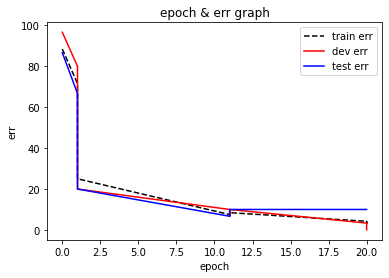

In [17]:
if (to_train) :
  plt.plot(x_epoch, y_train_err, color = 'black', label = 'train err', linestyle = '--')
  plt.plot(x_epoch, y_dev_err, color = 'red', label = 'dev err')
  plt.plot(x_epoch, y_test_err, color = 'blue', label = 'test err')

  plt.xlabel('epoch')
  plt.ylabel('err')
  plt.title('epoch & err graph')
  plt.legend(loc = 'upper right')
  plt.show()

6. Evaluation for dev & test data

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Normalized confusion matrix


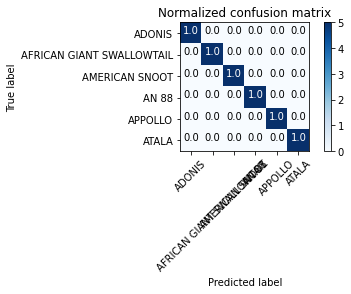

Confusion matrix, without normalization


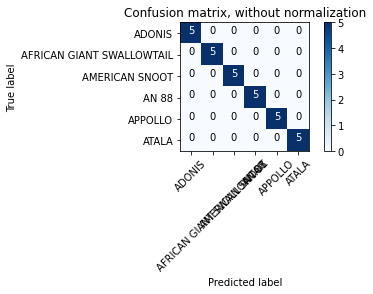

	 acc  |	 pre  |	 rec  |	 f1
 ADONIS: 1.00 |	 1.00 |	 1.00 |	 1.00
 AFRICAN GIANT SWALLOWTAIL: 1.00 |	 1.00 |	 1.00 |	 1.00
 AMERICAN SNOOT: 1.00 |	 1.00 |	 1.00 |	 1.00
 AN 88: 1.00 |	 1.00 |	 1.00 |	 1.00
 APPOLLO: 1.00 |	 1.00 |	 1.00 |	 1.00
 ATALA: 1.00 |	 1.00 |	 1.00 |	 1.00
*accuracy: 1.00, precision: 1.00, recall: 1.00, *f1 score: 1.00
[AP]
ADONIS: 0.94
AFRICAN GIANT SWALLOWTAIL: 1.00
AMERICAN SNOOT: 1.00
AN 88: 1.00
APPOLLO: 1.00
ATALA: 1.00

[mAP] 0.990
[miAP] 1.000


(array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4,
        4, 4, 4, 5, 5, 5, 5, 5]),
 array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4,
        4, 4, 4, 5, 5, 5, 5, 5]),
 array([0.58781767, 0.87162977, 0.6396603 , 0.85789931, 0.33810505,
        0.49948451, 0.53704423, 0.36433879, 0.51704746, 0.65537697,
        0.56726229, 0.52154016, 0.42017055, 0.55287641, 0.45876285,
        0.28765798, 0.78842396, 0.40041149, 0.62513179, 0.69377172,
        0.520661  , 0.31419262, 0.46339652, 0.67813492, 0.54575861,
        0.3475945 , 0.70482165, 0.93250531, 0.38744351, 0.6576162 ]))

In [18]:
model.eval()
utils.EvaluateClassifier(dev_batch, model, dev_data.classes, batch_size)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Normalized confusion matrix


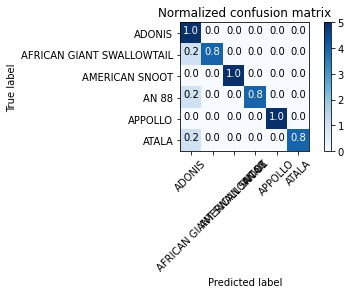

Confusion matrix, without normalization


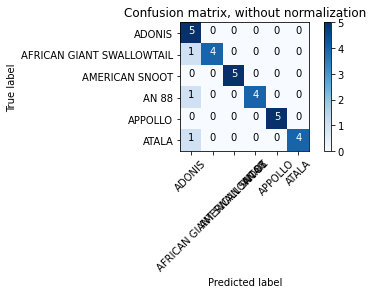

	 acc  |	 pre  |	 rec  |	 f1
 ADONIS: 0.90 |	 0.62 |	 1.00 |	 0.77
 AFRICAN GIANT SWALLOWTAIL: 0.90 |	 1.00 |	 0.80 |	 0.89
 AMERICAN SNOOT: 0.93 |	 1.00 |	 1.00 |	 1.00
 AN 88: 0.93 |	 1.00 |	 0.80 |	 0.89
 APPOLLO: 0.97 |	 1.00 |	 1.00 |	 1.00
 ATALA: 0.97 |	 1.00 |	 0.80 |	 0.89
*accuracy: 0.93, precision: 0.94, recall: 0.90, *f1 score: 0.91
[AP]
ADONIS: 1.00
AFRICAN GIANT SWALLOWTAIL: 1.00
AMERICAN SNOOT: 1.00
AN 88: 1.00
APPOLLO: 1.00
ATALA: 1.00

[mAP] 1.000
[miAP] 0.983


In [19]:
model.eval()
_, _, _ = utils.EvaluateClassifier(test_batch, model, test_data.classes, batch_size)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Category: ADONIS
 True predicted images/total ADONIS category: 5 / 5
Predicted probability:
[0.58781767 0.0780115  0.10669124 0.10148773 0.08293745 0.04305439]


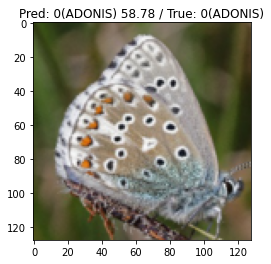

 False predicted images/total ADONIS category: 0 / 5
Category: AFRICAN GIANT SWALLOWTAIL
 True predicted images/total AFRICAN GIANT SWALLOWTAIL category: 5 / 5
Predicted probability:
[0.33147916 0.4994845  0.0749544  0.06252653 0.01480846 0.01674694]


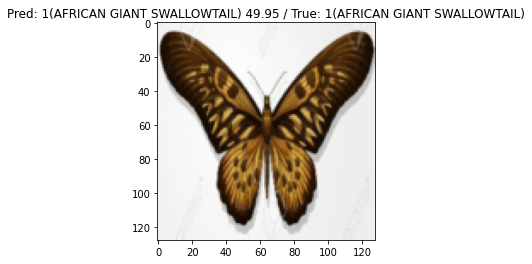

 False predicted images/total AFRICAN GIANT SWALLOWTAIL category: 0 / 5
Category: AMERICAN SNOOT
 True predicted images/total AMERICAN SNOOT category: 5 / 5
Predicted probability:
[0.11980675 0.08015119 0.5672623  0.12467177 0.06292792 0.04518008]


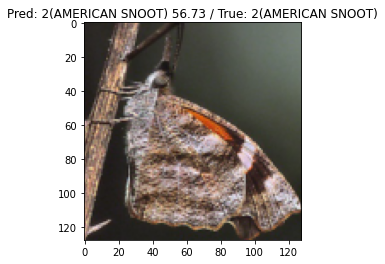

 False predicted images/total AMERICAN SNOOT category: 0 / 5
Category: AN 88
 True predicted images/total AN 88 category: 5 / 5
Predicted probability:
[0.26494268 0.1543744  0.12252052 0.28765798 0.05173789 0.11876654]


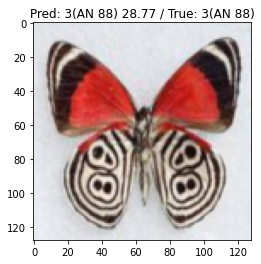

 False predicted images/total AN 88 category: 0 / 5
Category: APPOLLO
 True predicted images/total APPOLLO category: 5 / 5
Predicted probability:
[0.20570529 0.06785132 0.03985965 0.12904954 0.520661   0.03687321]


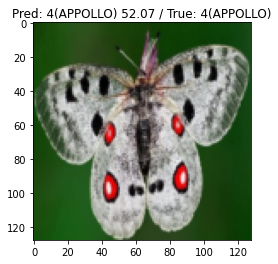

 False predicted images/total APPOLLO category: 0 / 5
Category: ATALA
 True predicted images/total ATALA category: 5 / 5
Predicted probability:
[0.24043216 0.08861323 0.07407498 0.12116312 0.12812202 0.3475945 ]


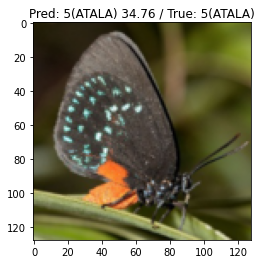

 False predicted images/total ATALA category: 0 / 5


In [20]:
utils.VisTFPred(dev_batch, model, test_data.classes, batch_size, i_n = 1)